# Transfer Learning Template

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

    
import os, json, sys, time, random
import numpy as np
import torch
from torch.optim import Adam
from  easydict import EasyDict
import matplotlib.pyplot as plt

from steves_models.steves_ptn import Steves_Prototypical_Network

from steves_utils.lazy_iterable_wrapper import Lazy_Iterable_Wrapper
from steves_utils.iterable_aggregator import Iterable_Aggregator
from steves_utils.ptn_train_eval_test_jig import  PTN_Train_Eval_Test_Jig
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.torch_utils import get_dataset_metrics, ptn_confusion_by_domain_over_dataloader
from steves_utils.utils_v2 import (per_domain_accuracy_from_confusion, get_datasets_base_path)
from steves_utils.PTN.utils import independent_accuracy_assesment

from torch.utils.data import DataLoader

from steves_utils.stratified_dataset.episodic_accessor import Episodic_Accessor_Factory

from steves_utils.ptn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.transforms import get_chained_transform

# Allowed Parameters
These are allowed parameters, not defaults
Each of these values need to be present in the injected parameters (the notebook will raise an exception if they are not present)

Papermill uses the cell tag "parameters" to inject the real parameters below this cell.
Enable tags to see what I mean

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "seed",
    "dataset_seed",
    "n_shot",
    "n_query",
    "n_way",
    "train_k_factor",
    "val_k_factor",
    "test_k_factor",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "x_net",
    "datasets",
    "torch_default_dtype",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "x_shape",
}

In [3]:
from steves_utils.CORES.utils import (
    ALL_NODES,
    ALL_NODES_MINIMUM_1000_EXAMPLES,
    ALL_DAYS
)

from steves_utils.ORACLE.utils_v2 import (
    ALL_DISTANCES_FEET_NARROWED,
    ALL_RUNS,
    ALL_SERIAL_NUMBERS,
)

standalone_parameters = {}
standalone_parameters["experiment_name"] = "STANDALONE PTN"
standalone_parameters["lr"] = 0.001
standalone_parameters["device"] = "cuda"

standalone_parameters["seed"] = 1337
standalone_parameters["dataset_seed"] = 1337

standalone_parameters["n_way"] = 8
standalone_parameters["n_shot"] = 3
standalone_parameters["n_query"]  = 2
standalone_parameters["train_k_factor"] = 1
standalone_parameters["val_k_factor"] = 2
standalone_parameters["test_k_factor"] = 2


standalone_parameters["n_epoch"] = 50

standalone_parameters["patience"] = 10
standalone_parameters["criteria_for_best"] = "source_loss"

standalone_parameters["datasets"] = [
    {
        "labels": ALL_SERIAL_NUMBERS,
        "domains": ALL_DISTANCES_FEET_NARROWED,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "source",
        "x_transforms": ["unit_mag", "minus_two"],
        "episode_transforms": [],
        "domain_prefix": "ORACLE_"
    },
    {
        "labels": ALL_NODES,
        "domains": ALL_DAYS,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "target",
        "x_transforms": ["unit_power", "times_zero"],
        "episode_transforms": [],
        "domain_prefix": "CORES_"
    }   
]

standalone_parameters["torch_default_dtype"] = "torch.float32" 



standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
]

# Parameters relevant to results
# These parameters will basically never need to change
standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"






In [4]:
# Parameters
parameters = {
    "experiment_name": "tl_1v2:wisig-oracle.run1.limited",
    "device": "cuda",
    "lr": 0.0001,
    "n_shot": 3,
    "n_query": 2,
    "train_k_factor": 3,
    "val_k_factor": 2,
    "test_k_factor": 2,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "n_way": 16,
    "datasets": [
        {
            "labels": [
                "1-10",
                "1-12",
                "1-14",
                "1-16",
                "1-18",
                "1-19",
                "1-8",
                "10-11",
                "10-17",
                "10-4",
                "10-7",
                "11-1",
                "11-10",
                "11-19",
                "11-20",
                "11-4",
                "11-7",
                "12-19",
                "12-20",
                "12-7",
                "13-14",
                "13-18",
                "13-19",
                "13-20",
                "13-3",
                "13-7",
                "14-10",
                "14-11",
                "14-12",
                "14-13",
                "14-14",
                "14-19",
                "14-20",
                "14-7",
                "14-8",
                "14-9",
                "15-1",
                "15-19",
                "15-6",
                "16-1",
                "16-16",
                "16-19",
                "16-20",
                "17-10",
                "17-11",
                "18-1",
                "18-10",
                "18-11",
                "18-12",
                "18-13",
                "18-14",
                "18-15",
                "18-16",
                "18-17",
                "18-19",
                "18-2",
                "18-20",
                "18-4",
                "18-5",
                "18-7",
                "18-8",
                "18-9",
                "19-1",
                "19-10",
                "19-11",
                "19-12",
                "19-13",
                "19-14",
                "19-15",
                "19-19",
                "19-2",
                "19-20",
                "19-3",
                "19-4",
                "19-6",
                "19-7",
                "19-8",
                "19-9",
                "2-1",
                "2-13",
                "2-15",
                "2-3",
                "2-4",
                "2-5",
                "2-6",
                "2-7",
                "2-8",
                "20-1",
                "20-12",
                "20-14",
                "20-15",
                "20-16",
                "20-18",
                "20-19",
                "20-20",
                "20-3",
                "20-4",
                "20-5",
                "20-7",
                "20-8",
                "3-1",
                "3-13",
                "3-18",
                "3-2",
                "3-8",
                "4-1",
                "4-10",
                "4-11",
                "5-1",
                "5-5",
                "6-1",
                "6-15",
                "6-6",
                "7-10",
                "7-11",
                "7-12",
                "7-13",
                "7-14",
                "7-7",
                "7-8",
                "7-9",
                "8-1",
                "8-13",
                "8-14",
                "8-18",
                "8-20",
                "8-3",
                "8-8",
                "9-1",
                "9-7",
            ],
            "domains": [1, 2, 3, 4],
            "num_examples_per_domain_per_label": -1,
            "pickle_path": "/root/csc500-main/datasets/wisig.node3-19.stratified_ds.2022A.pkl",
            "source_or_target_dataset": "target",
            "x_transforms": ["unit_power"],
            "episode_transforms": [],
            "domain_prefix": "Wisig_",
        },
        {
            "labels": [
                "3123D52",
                "3123D65",
                "3123D79",
                "3123D80",
                "3123D54",
                "3123D70",
                "3123D7B",
                "3123D89",
                "3123D58",
                "3123D76",
                "3123D7D",
                "3123EFE",
                "3123D64",
                "3123D78",
                "3123D7E",
                "3124E4A",
            ],
            "domains": [32, 38, 8, 44, 14, 50, 20, 26],
            "num_examples_per_domain_per_label": 2000,
            "pickle_path": "/root/csc500-main/datasets/oracle.Run1_10kExamples_stratified_ds.2022A.pkl",
            "source_or_target_dataset": "source",
            "x_transforms": ["unit_power"],
            "episode_transforms": [],
            "domain_prefix": "ORACLE.run1",
        },
    ],
    "dataset_seed": 154325,
    "seed": 154325,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

if "x_shape" not in p:
    p.x_shape = [2,256] # Default to this if we dont supply x_shape


supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")

In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
###########################################
# The stratified datasets honor this
###########################################
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
p.domains_source = []
p.domains_target = []


train_original_source = []
val_original_source   = []
test_original_source  = []

train_original_target = []
val_original_target   = []
test_original_target  = []

In [11]:
# global_x_transform_func = lambda x: normalize(x.to(torch.get_default_dtype()), "unit_power") # unit_power, unit_mag
# global_x_transform_func = lambda x: normalize(x, "unit_power") # unit_power, unit_mag

In [12]:
def add_dataset(
    labels,
    domains,
    pickle_path,
    x_transforms,
    episode_transforms,
    domain_prefix,
    num_examples_per_domain_per_label,
    source_or_target_dataset:str,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
):
   
    if x_transforms == []: x_transform = None
    else: x_transform = get_chained_transform(x_transforms)
    
    if episode_transforms == []: episode_transform = None
    else: raise Exception("episode_transforms not implemented")
    
    episode_transform = lambda tup, _prefix=domain_prefix: (_prefix + str(tup[0]), tup[1])


    eaf = Episodic_Accessor_Factory(
        labels=labels,
        domains=domains,
        num_examples_per_domain_per_label=num_examples_per_domain_per_label,
        iterator_seed=iterator_seed,
        dataset_seed=dataset_seed,
        n_shot=n_shot,
        n_way=n_way,
        n_query=n_query,
        train_val_test_k_factors=train_val_test_k_factors,
        pickle_path=pickle_path,
        x_transform_func=x_transform,
    )

    train, val, test = eaf.get_train(), eaf.get_val(), eaf.get_test()
    train = Lazy_Iterable_Wrapper(train, episode_transform)
    val = Lazy_Iterable_Wrapper(val, episode_transform)
    test = Lazy_Iterable_Wrapper(test, episode_transform)

    if source_or_target_dataset=="source":
        train_original_source.append(train)
        val_original_source.append(val)
        test_original_source.append(test)

        p.domains_source.extend(
            [domain_prefix + str(u) for u in domains]
        )
    elif source_or_target_dataset=="target":
        train_original_target.append(train)
        val_original_target.append(val)
        test_original_target.append(test)
        p.domains_target.extend(
            [domain_prefix + str(u) for u in domains]
        )
    else:
        raise Exception(f"invalid source_or_target_dataset: {source_or_target_dataset}")
    

In [13]:
for ds in p.datasets:
    add_dataset(**ds)

In [14]:
# from steves_utils.CORES.utils import (
#     ALL_NODES,
#     ALL_NODES_MINIMUM_1000_EXAMPLES,
#     ALL_DAYS
# )

# add_dataset(
#     labels=ALL_NODES,
#     domains = ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"cores_{u}"
# )

In [15]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle1_{u}"
# )


In [16]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62,56}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle2_{u}"
# )

In [17]:
# add_dataset(
#     labels=list(range(19)),
#     domains = [0,1,2],
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "metehan.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"met_{u}"
# )

In [18]:
# # from steves_utils.wisig.utils import (
# #     ALL_NODES_MINIMUM_100_EXAMPLES,
# #     ALL_NODES_MINIMUM_500_EXAMPLES,
# #     ALL_NODES_MINIMUM_1000_EXAMPLES,
# #     ALL_DAYS
# # )

# import steves_utils.wisig.utils as wisig


# add_dataset(
#     labels=wisig.ALL_NODES_MINIMUM_100_EXAMPLES,
#     domains = wisig.ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "wisig.node3-19.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"wisig_{u}"
# )

In [19]:
###################################
# Build the dataset
###################################
train_original_source = Iterable_Aggregator(train_original_source, p.seed)
val_original_source = Iterable_Aggregator(val_original_source, p.seed)
test_original_source = Iterable_Aggregator(test_original_source, p.seed)


train_original_target = Iterable_Aggregator(train_original_target, p.seed)
val_original_target = Iterable_Aggregator(val_original_target, p.seed)
test_original_target = Iterable_Aggregator(test_original_target, p.seed)

# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Iterable_Wrapper. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[1] # Original is (<domain>, <episode>) so we strip down to episode only

train_processed_source = Lazy_Iterable_Wrapper(train_original_source, transform_lambda)
val_processed_source   = Lazy_Iterable_Wrapper(val_original_source, transform_lambda)
test_processed_source  = Lazy_Iterable_Wrapper(test_original_source, transform_lambda)

train_processed_target = Lazy_Iterable_Wrapper(train_original_target, transform_lambda)
val_processed_target   = Lazy_Iterable_Wrapper(val_original_target, transform_lambda)
test_processed_target  = Lazy_Iterable_Wrapper(test_original_target, transform_lambda)

datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [20]:
from steves_utils.transforms import get_average_magnitude, get_average_power

print(set([u for u,_ in val_original_source]))
print(set([u for u,_ in val_original_target]))

s_x, s_y, q_x, q_y, _ = next(iter(train_processed_source))
print(s_x)

# for ds in [
#     train_processed_source,
#     val_processed_source,
#     test_processed_source,
#     train_processed_target,
#     val_processed_target,
#     test_processed_target
# ]:
#     for s_x, s_y, q_x, q_y, _ in ds:
#         for X in (s_x, q_x):
#             for x in X:
#                 assert np.isclose(get_average_magnitude(x.numpy()), 1.0)
#                 assert np.isclose(get_average_power(x.numpy()), 1.0)
                

{'ORACLE.run132', 'ORACLE.run144', 'ORACLE.run18', 'ORACLE.run138', 'ORACLE.run120', 'ORACLE.run114', 'ORACLE.run150', 'ORACLE.run126'}


{'Wisig_1', 'Wisig_4', 'Wisig_3', 'Wisig_2'}


tensor([[[ 0.2134, -0.3315, -0.6902,  ...,  0.1635, -0.0727,  0.3224],
         [ 0.0091,  0.8764, -0.3587,  ...,  0.0136,  0.2089,  0.7856]],

        [[-0.3342, -0.5662,  0.4920,  ...,  0.4084, -0.2738, -0.0278],
         [ 0.0975, -0.1021,  1.6429,  ...,  0.7286,  0.0464, -0.5523]],

        [[ 0.2644, -0.2876, -0.5613,  ..., -1.2524,  0.1345,  1.2942],
         [-1.1179, -0.1206,  0.4917,  ...,  0.3618,  0.5891,  0.5010]],

        ...,

        [[ 0.6196,  1.0273,  0.8684,  ...,  0.5295, -0.4978, -1.1173],
         [ 0.1430,  0.7149, -0.8102,  ...,  0.2542,  0.4395, -0.3283]],

        [[ 0.3250, -0.1733, -1.1699,  ...,  0.5903,  0.8936, -0.1462],
         [-0.6824,  0.5145, -0.1408,  ..., -0.6174,  0.0596,  1.4407]],

        [[-1.2461, -0.3851,  0.3423,  ..., -1.0215,  0.2032, -0.1284],
         [ 0.1284, -0.8504, -0.9039,  ..., -0.0856,  0.4760,  0.8825]]])


In [21]:
###################################
# Build the model
###################################
# easfsl only wants a tuple for the shape
model = Steves_Prototypical_Network(x_net, device=p.device, x_shape=tuple(p.x_shape))
optimizer = Adam(params=model.parameters(), lr=p.lr)

(2, 256)


In [22]:
###################################
# train
###################################
jig = PTN_Train_Eval_Test_Jig(model, p.BEST_MODEL_PATH, p.device)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    patience=p.patience,
    optimizer=optimizer,
    criteria_for_best=p.criteria_for_best,
)

epoch: 1, [batch: 1 / 6720], examples_per_second: 33.6331, train_label_loss: 2.7904, 


epoch: 1, [batch: 672 / 6720], examples_per_second: 3842.5927, train_label_loss: 2.5492, 


epoch: 1, [batch: 1344 / 6720], examples_per_second: 3808.5099, train_label_loss: 1.3638, 


epoch: 1, [batch: 2016 / 6720], examples_per_second: 3827.1964, train_label_loss: 1.4918, 


epoch: 1, [batch: 2688 / 6720], examples_per_second: 3778.4405, train_label_loss: 1.5275, 


epoch: 1, [batch: 3360 / 6720], examples_per_second: 3895.4709, train_label_loss: 1.3054, 


epoch: 1, [batch: 4032 / 6720], examples_per_second: 3878.6904, train_label_loss: 1.0077, 


epoch: 1, [batch: 4704 / 6720], examples_per_second: 3837.6270, train_label_loss: 1.1551, 


epoch: 1, [batch: 5376 / 6720], examples_per_second: 3881.9928, train_label_loss: 0.8223, 


epoch: 1, [batch: 6048 / 6720], examples_per_second: 3873.1888, train_label_loss: 0.8320, 


epoch: 1, source_val_acc_label: 0.5388, target_val_acc_label: 0.6252, source_val_label_loss: 1.2007, target_val_label_loss: 5.7097, 


New best


epoch: 2, [batch: 1 / 6720], examples_per_second: 3.8928, train_label_loss: 0.7521, 


epoch: 2, [batch: 672 / 6720], examples_per_second: 3887.7078, train_label_loss: 0.9549, 


epoch: 2, [batch: 1344 / 6720], examples_per_second: 3989.7493, train_label_loss: 1.4671, 


epoch: 2, [batch: 2016 / 6720], examples_per_second: 3959.5932, train_label_loss: 0.6927, 


epoch: 2, [batch: 2688 / 6720], examples_per_second: 3942.0613, train_label_loss: 0.9734, 


epoch: 2, [batch: 3360 / 6720], examples_per_second: 3909.4529, train_label_loss: 0.9062, 


epoch: 2, [batch: 4032 / 6720], examples_per_second: 3794.7307, train_label_loss: 0.6720, 


epoch: 2, [batch: 4704 / 6720], examples_per_second: 3760.2181, train_label_loss: 0.5564, 


epoch: 2, [batch: 5376 / 6720], examples_per_second: 3803.0714, train_label_loss: 1.4105, 


epoch: 2, [batch: 6048 / 6720], examples_per_second: 3836.2174, train_label_loss: 0.8027, 


epoch: 2, source_val_acc_label: 0.5923, target_val_acc_label: 0.6480, source_val_label_loss: 1.0640, target_val_label_loss: 6.9288, 


New best


epoch: 3, [batch: 1 / 6720], examples_per_second: 4.2403, train_label_loss: 1.3877, 


epoch: 3, [batch: 672 / 6720], examples_per_second: 4335.5633, train_label_loss: 1.1125, 


epoch: 3, [batch: 1344 / 6720], examples_per_second: 4464.8247, train_label_loss: 0.6232, 


epoch: 3, [batch: 2016 / 6720], examples_per_second: 5013.3490, train_label_loss: 0.8956, 


epoch: 3, [batch: 2688 / 6720], examples_per_second: 4986.4719, train_label_loss: 0.9386, 


epoch: 3, [batch: 3360 / 6720], examples_per_second: 3774.7609, train_label_loss: 0.5969, 


epoch: 3, [batch: 4032 / 6720], examples_per_second: 3841.9230, train_label_loss: 0.4855, 


epoch: 3, [batch: 4704 / 6720], examples_per_second: 3890.0089, train_label_loss: 0.8634, 


epoch: 3, [batch: 5376 / 6720], examples_per_second: 3928.2877, train_label_loss: 0.7299, 


epoch: 3, [batch: 6048 / 6720], examples_per_second: 3820.7677, train_label_loss: 0.7467, 


epoch: 3, source_val_acc_label: 0.6070, target_val_acc_label: 0.6661, source_val_label_loss: 1.0424, target_val_label_loss: 8.6082, 


New best


epoch: 4, [batch: 1 / 6720], examples_per_second: 3.8898, train_label_loss: 0.4378, 


epoch: 4, [batch: 672 / 6720], examples_per_second: 3820.1637, train_label_loss: 0.6578, 


epoch: 4, [batch: 1344 / 6720], examples_per_second: 3875.4336, train_label_loss: 0.6394, 


epoch: 4, [batch: 2016 / 6720], examples_per_second: 3862.4722, train_label_loss: 0.3595, 


epoch: 4, [batch: 2688 / 6720], examples_per_second: 3907.1168, train_label_loss: 0.3982, 


epoch: 4, [batch: 3360 / 6720], examples_per_second: 3893.0002, train_label_loss: 0.9782, 


epoch: 4, [batch: 4032 / 6720], examples_per_second: 4035.5956, train_label_loss: 1.0301, 


epoch: 4, [batch: 4704 / 6720], examples_per_second: 3949.9370, train_label_loss: 0.4549, 


epoch: 4, [batch: 5376 / 6720], examples_per_second: 3935.5955, train_label_loss: 0.7406, 


epoch: 4, [batch: 6048 / 6720], examples_per_second: 3929.7537, train_label_loss: 0.3665, 


epoch: 4, source_val_acc_label: 0.6168, target_val_acc_label: 0.6702, source_val_label_loss: 1.0703, target_val_label_loss: 9.9740, 


New best


epoch: 5, [batch: 1 / 6720], examples_per_second: 3.9693, train_label_loss: 0.6705, 


epoch: 5, [batch: 672 / 6720], examples_per_second: 3845.2446, train_label_loss: 0.4751, 


epoch: 5, [batch: 1344 / 6720], examples_per_second: 3871.2223, train_label_loss: 0.7476, 


epoch: 5, [batch: 2016 / 6720], examples_per_second: 3856.9426, train_label_loss: 0.8577, 


epoch: 5, [batch: 2688 / 6720], examples_per_second: 3974.2946, train_label_loss: 0.6392, 


epoch: 5, [batch: 3360 / 6720], examples_per_second: 4055.6004, train_label_loss: 1.0750, 


epoch: 5, [batch: 4032 / 6720], examples_per_second: 4008.6133, train_label_loss: 0.4203, 


epoch: 5, [batch: 4704 / 6720], examples_per_second: 4036.5633, train_label_loss: 0.3867, 


epoch: 5, [batch: 5376 / 6720], examples_per_second: 4029.8843, train_label_loss: 0.5828, 


epoch: 5, [batch: 6048 / 6720], examples_per_second: 4066.4366, train_label_loss: 0.3539, 


epoch: 5, source_val_acc_label: 0.6064, target_val_acc_label: 0.6747, source_val_label_loss: 1.0982, target_val_label_loss: 10.6497, 


New best


epoch: 6, [batch: 1 / 6720], examples_per_second: 3.8987, train_label_loss: 0.7691, 


epoch: 6, [batch: 672 / 6720], examples_per_second: 4034.3136, train_label_loss: 0.3892, 


epoch: 6, [batch: 1344 / 6720], examples_per_second: 4031.7988, train_label_loss: 0.7518, 


epoch: 6, [batch: 2016 / 6720], examples_per_second: 4042.1030, train_label_loss: 0.5274, 


epoch: 6, [batch: 2688 / 6720], examples_per_second: 3978.6326, train_label_loss: 0.5975, 


epoch: 6, [batch: 3360 / 6720], examples_per_second: 3989.5020, train_label_loss: 0.6357, 


epoch: 6, [batch: 4032 / 6720], examples_per_second: 4019.2551, train_label_loss: 0.5889, 


epoch: 6, [batch: 4704 / 6720], examples_per_second: 3858.6104, train_label_loss: 0.6133, 


epoch: 6, [batch: 5376 / 6720], examples_per_second: 3802.0986, train_label_loss: 0.3856, 


epoch: 6, [batch: 6048 / 6720], examples_per_second: 3807.3882, train_label_loss: 0.6744, 


epoch: 6, source_val_acc_label: 0.6062, target_val_acc_label: 0.6758, source_val_label_loss: 1.1734, target_val_label_loss: 11.8761, 


New best


epoch: 7, [batch: 1 / 6720], examples_per_second: 3.8923, train_label_loss: 0.2561, 


epoch: 7, [batch: 672 / 6720], examples_per_second: 3857.4048, train_label_loss: 0.3561, 


epoch: 7, [batch: 1344 / 6720], examples_per_second: 3843.7407, train_label_loss: 0.4569, 


epoch: 7, [batch: 2016 / 6720], examples_per_second: 3948.4888, train_label_loss: 0.2091, 


epoch: 7, [batch: 2688 / 6720], examples_per_second: 4025.2710, train_label_loss: 0.4902, 


epoch: 7, [batch: 3360 / 6720], examples_per_second: 4155.4109, train_label_loss: 0.2276, 


epoch: 7, [batch: 4032 / 6720], examples_per_second: 4370.8490, train_label_loss: 0.2267, 


epoch: 7, [batch: 4704 / 6720], examples_per_second: 4352.8855, train_label_loss: 0.5037, 


epoch: 7, [batch: 5376 / 6720], examples_per_second: 4307.7173, train_label_loss: 0.7813, 


epoch: 7, [batch: 6048 / 6720], examples_per_second: 4250.2725, train_label_loss: 0.4391, 


epoch: 7, source_val_acc_label: 0.5995, target_val_acc_label: 0.6750, source_val_label_loss: 1.2296, target_val_label_loss: 12.7462, 


epoch: 8, [batch: 1 / 6720], examples_per_second: 5.0070, train_label_loss: 0.5509, 


epoch: 8, [batch: 672 / 6720], examples_per_second: 4055.2245, train_label_loss: 0.3070, 


epoch: 8, [batch: 1344 / 6720], examples_per_second: 3851.1087, train_label_loss: 0.1937, 


epoch: 8, [batch: 2016 / 6720], examples_per_second: 3907.2318, train_label_loss: 0.3520, 


epoch: 8, [batch: 2688 / 6720], examples_per_second: 3930.5631, train_label_loss: 0.4406, 


epoch: 8, [batch: 3360 / 6720], examples_per_second: 3900.0754, train_label_loss: 0.7842, 


epoch: 8, [batch: 4032 / 6720], examples_per_second: 3949.1046, train_label_loss: 0.1717, 


epoch: 8, [batch: 4704 / 6720], examples_per_second: 3879.0824, train_label_loss: 0.1566, 


epoch: 8, [batch: 5376 / 6720], examples_per_second: 3909.3949, train_label_loss: 0.1939, 


epoch: 8, [batch: 6048 / 6720], examples_per_second: 3825.9435, train_label_loss: 0.8170, 


epoch: 8, source_val_acc_label: 0.6031, target_val_acc_label: 0.6767, source_val_label_loss: 1.3148, target_val_label_loss: 14.4523, 


New best


epoch: 9, [batch: 1 / 6720], examples_per_second: 3.8719, train_label_loss: 0.4913, 


epoch: 9, [batch: 672 / 6720], examples_per_second: 3887.1402, train_label_loss: 0.5388, 


epoch: 9, [batch: 1344 / 6720], examples_per_second: 3938.2119, train_label_loss: 0.2940, 


epoch: 9, [batch: 2016 / 6720], examples_per_second: 3960.6313, train_label_loss: 0.4045, 


epoch: 9, [batch: 2688 / 6720], examples_per_second: 3850.4578, train_label_loss: 0.3041, 


epoch: 9, [batch: 3360 / 6720], examples_per_second: 3965.5825, train_label_loss: 0.2012, 


epoch: 9, [batch: 4032 / 6720], examples_per_second: 3927.9377, train_label_loss: 0.3379, 


epoch: 9, [batch: 4704 / 6720], examples_per_second: 3930.3428, train_label_loss: 0.3806, 


epoch: 9, [batch: 5376 / 6720], examples_per_second: 4060.9041, train_label_loss: 0.0782, 


epoch: 9, [batch: 6048 / 6720], examples_per_second: 3976.6658, train_label_loss: 0.3480, 


epoch: 9, source_val_acc_label: 0.6021, target_val_acc_label: 0.6741, source_val_label_loss: 1.3932, target_val_label_loss: 15.8305, 


epoch: 10, [batch: 1 / 6720], examples_per_second: 3.9124, train_label_loss: 0.5100, 


epoch: 10, [batch: 672 / 6720], examples_per_second: 3860.3934, train_label_loss: 0.9104, 


epoch: 10, [batch: 1344 / 6720], examples_per_second: 3879.6949, train_label_loss: 0.4360, 


epoch: 10, [batch: 2016 / 6720], examples_per_second: 3916.3028, train_label_loss: 0.1239, 


epoch: 10, [batch: 2688 / 6720], examples_per_second: 4003.0599, train_label_loss: 0.2794, 


epoch: 10, [batch: 3360 / 6720], examples_per_second: 3884.2741, train_label_loss: 0.4524, 


epoch: 10, [batch: 4032 / 6720], examples_per_second: 3885.2057, train_label_loss: 0.1481, 


epoch: 10, [batch: 4704 / 6720], examples_per_second: 3782.5396, train_label_loss: 0.1063, 


epoch: 10, [batch: 5376 / 6720], examples_per_second: 3935.6193, train_label_loss: 0.4648, 


epoch: 10, [batch: 6048 / 6720], examples_per_second: 3967.1678, train_label_loss: 0.2121, 


epoch: 10, source_val_acc_label: 0.5962, target_val_acc_label: 0.6860, source_val_label_loss: 1.5035, target_val_label_loss: 16.4085, 


New best


epoch: 11, [batch: 1 / 6720], examples_per_second: 3.8599, train_label_loss: 0.0959, 


epoch: 11, [batch: 672 / 6720], examples_per_second: 3812.1897, train_label_loss: 0.4319, 


epoch: 11, [batch: 1344 / 6720], examples_per_second: 3811.4653, train_label_loss: 0.4714, 


epoch: 11, [batch: 2016 / 6720], examples_per_second: 3843.4581, train_label_loss: 0.3034, 


epoch: 11, [batch: 2688 / 6720], examples_per_second: 3801.2165, train_label_loss: 0.0618, 


epoch: 11, [batch: 3360 / 6720], examples_per_second: 3813.9198, train_label_loss: 0.3854, 


epoch: 11, [batch: 4032 / 6720], examples_per_second: 3922.3401, train_label_loss: 0.0995, 


epoch: 11, [batch: 4704 / 6720], examples_per_second: 3952.1765, train_label_loss: 0.2332, 


epoch: 11, [batch: 5376 / 6720], examples_per_second: 3934.7740, train_label_loss: 0.2732, 


epoch: 11, [batch: 6048 / 6720], examples_per_second: 3901.5635, train_label_loss: 0.3053, 


epoch: 11, source_val_acc_label: 0.6013, target_val_acc_label: 0.6869, source_val_label_loss: 1.5983, target_val_label_loss: 18.0684, 


New best


epoch: 12, [batch: 1 / 6720], examples_per_second: 3.8917, train_label_loss: 0.1847, 


epoch: 12, [batch: 672 / 6720], examples_per_second: 3917.4843, train_label_loss: 0.0646, 


epoch: 12, [batch: 1344 / 6720], examples_per_second: 4265.5332, train_label_loss: 0.1266, 


epoch: 12, [batch: 2016 / 6720], examples_per_second: 4322.1264, train_label_loss: 0.2719, 


epoch: 12, [batch: 2688 / 6720], examples_per_second: 4287.6833, train_label_loss: 0.0240, 


epoch: 12, [batch: 3360 / 6720], examples_per_second: 4589.9435, train_label_loss: 0.4268, 


epoch: 12, [batch: 4032 / 6720], examples_per_second: 4666.6701, train_label_loss: 0.2751, 


epoch: 12, [batch: 4704 / 6720], examples_per_second: 5134.4456, train_label_loss: 0.3688, 


epoch: 12, [batch: 5376 / 6720], examples_per_second: 5302.0496, train_label_loss: 0.2304, 


epoch: 12, [batch: 6048 / 6720], examples_per_second: 4232.6900, train_label_loss: 0.0930, 


epoch: 12, source_val_acc_label: 0.5936, target_val_acc_label: 0.6746, source_val_label_loss: 1.6767, target_val_label_loss: 19.0099, 


epoch: 13, [batch: 1 / 6720], examples_per_second: 3.9388, train_label_loss: 0.2468, 


epoch: 13, [batch: 672 / 6720], examples_per_second: 3856.3047, train_label_loss: 0.2332, 


epoch: 13, [batch: 1344 / 6720], examples_per_second: 3819.1308, train_label_loss: 0.0460, 


epoch: 13, [batch: 2016 / 6720], examples_per_second: 3830.4171, train_label_loss: 0.1043, 


epoch: 13, [batch: 2688 / 6720], examples_per_second: 3804.8989, train_label_loss: 0.1254, 


epoch: 13, [batch: 3360 / 6720], examples_per_second: 3901.4614, train_label_loss: 0.1048, 


epoch: 13, [batch: 4032 / 6720], examples_per_second: 3955.2349, train_label_loss: 0.1160, 


epoch: 13, [batch: 4704 / 6720], examples_per_second: 3951.9581, train_label_loss: 0.1496, 


epoch: 13, [batch: 5376 / 6720], examples_per_second: 3992.5950, train_label_loss: 0.2740, 


epoch: 13, [batch: 6048 / 6720], examples_per_second: 4026.4432, train_label_loss: 0.7400, 


epoch: 13, source_val_acc_label: 0.6011, target_val_acc_label: 0.6895, source_val_label_loss: 1.7203, target_val_label_loss: 19.8408, 


New best


epoch: 14, [batch: 1 / 6720], examples_per_second: 3.8738, train_label_loss: 0.2229, 


epoch: 14, [batch: 672 / 6720], examples_per_second: 3890.4616, train_label_loss: 0.2094, 


epoch: 14, [batch: 1344 / 6720], examples_per_second: 3910.9404, train_label_loss: 0.4979, 


epoch: 14, [batch: 2016 / 6720], examples_per_second: 3927.0288, train_label_loss: 0.2477, 


epoch: 14, [batch: 2688 / 6720], examples_per_second: 3927.1769, train_label_loss: 0.3661, 


epoch: 14, [batch: 3360 / 6720], examples_per_second: 3909.4600, train_label_loss: 0.1417, 


epoch: 14, [batch: 4032 / 6720], examples_per_second: 3862.9845, train_label_loss: 0.0080, 


epoch: 14, [batch: 4704 / 6720], examples_per_second: 3748.6948, train_label_loss: 0.3078, 


epoch: 14, [batch: 5376 / 6720], examples_per_second: 3789.2873, train_label_loss: 0.0140, 


epoch: 14, [batch: 6048 / 6720], examples_per_second: 3832.0174, train_label_loss: 0.3899, 


epoch: 14, source_val_acc_label: 0.5997, target_val_acc_label: 0.6881, source_val_label_loss: 1.7814, target_val_label_loss: 20.7288, 


epoch: 15, [batch: 1 / 6720], examples_per_second: 3.9620, train_label_loss: 0.3995, 


epoch: 15, [batch: 672 / 6720], examples_per_second: 3798.6767, train_label_loss: 0.1558, 


epoch: 15, [batch: 1344 / 6720], examples_per_second: 3821.5492, train_label_loss: 0.2079, 


epoch: 15, [batch: 2016 / 6720], examples_per_second: 3991.4193, train_label_loss: 0.3772, 


epoch: 15, [batch: 2688 / 6720], examples_per_second: 3825.6202, train_label_loss: 0.1518, 


epoch: 15, [batch: 3360 / 6720], examples_per_second: 3951.3435, train_label_loss: 0.3696, 


epoch: 15, [batch: 4032 / 6720], examples_per_second: 3933.3303, train_label_loss: 0.4791, 


epoch: 15, [batch: 4704 / 6720], examples_per_second: 3905.8516, train_label_loss: 0.1078, 


epoch: 15, [batch: 5376 / 6720], examples_per_second: 3869.0767, train_label_loss: 0.1255, 


epoch: 15, [batch: 6048 / 6720], examples_per_second: 3916.1360, train_label_loss: 0.1299, 


epoch: 15, source_val_acc_label: 0.5982, target_val_acc_label: 0.6890, source_val_label_loss: 1.8577, target_val_label_loss: 21.9240, 


epoch: 16, [batch: 1 / 6720], examples_per_second: 3.9486, train_label_loss: 0.0419, 


epoch: 16, [batch: 672 / 6720], examples_per_second: 3805.8206, train_label_loss: 0.2649, 


epoch: 16, [batch: 1344 / 6720], examples_per_second: 3928.2769, train_label_loss: 0.0994, 


epoch: 16, [batch: 2016 / 6720], examples_per_second: 3938.3440, train_label_loss: 0.1933, 


epoch: 16, [batch: 2688 / 6720], examples_per_second: 3918.7872, train_label_loss: 0.1499, 


epoch: 16, [batch: 3360 / 6720], examples_per_second: 3941.7453, train_label_loss: 0.1269, 


epoch: 16, [batch: 4032 / 6720], examples_per_second: 4022.6176, train_label_loss: 0.1399, 


epoch: 16, [batch: 4704 / 6720], examples_per_second: 4010.1073, train_label_loss: 0.0356, 


epoch: 16, [batch: 5376 / 6720], examples_per_second: 4137.9719, train_label_loss: 0.3980, 


epoch: 16, [batch: 6048 / 6720], examples_per_second: 3910.0945, train_label_loss: 0.0271, 


epoch: 16, source_val_acc_label: 0.5991, target_val_acc_label: 0.6880, source_val_label_loss: 1.9088, target_val_label_loss: 22.7721, 


epoch: 17, [batch: 1 / 6720], examples_per_second: 4.2284, train_label_loss: 0.0262, 


epoch: 17, [batch: 672 / 6720], examples_per_second: 4369.4532, train_label_loss: 0.1744, 


epoch: 17, [batch: 1344 / 6720], examples_per_second: 4439.7837, train_label_loss: 0.3446, 


epoch: 17, [batch: 2016 / 6720], examples_per_second: 5384.1618, train_label_loss: 0.2092, 


epoch: 17, [batch: 2688 / 6720], examples_per_second: 5409.4304, train_label_loss: 0.0171, 


epoch: 17, [batch: 3360 / 6720], examples_per_second: 4810.7947, train_label_loss: 0.0562, 


epoch: 17, [batch: 4032 / 6720], examples_per_second: 3976.7007, train_label_loss: 0.4563, 


epoch: 17, [batch: 4704 / 6720], examples_per_second: 3774.1090, train_label_loss: 0.0799, 


epoch: 17, [batch: 5376 / 6720], examples_per_second: 3803.5170, train_label_loss: 0.2127, 


epoch: 17, [batch: 6048 / 6720], examples_per_second: 3840.0663, train_label_loss: 0.0239, 


epoch: 17, source_val_acc_label: 0.5953, target_val_acc_label: 0.6876, source_val_label_loss: 1.9752, target_val_label_loss: 23.2289, 


Patience (3) exhausted


In [23]:
total_experiment_time_secs = time.time() - start_time_secs

In [24]:
###################################
# Evaluate the model
###################################
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = Iterable_Aggregator((datasets.source.original.val,datasets.target.original.val))

confusion = ptn_confusion_by_domain_over_dataloader(model, p.device, val_dl)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": dict(p),
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "ptn"),
}

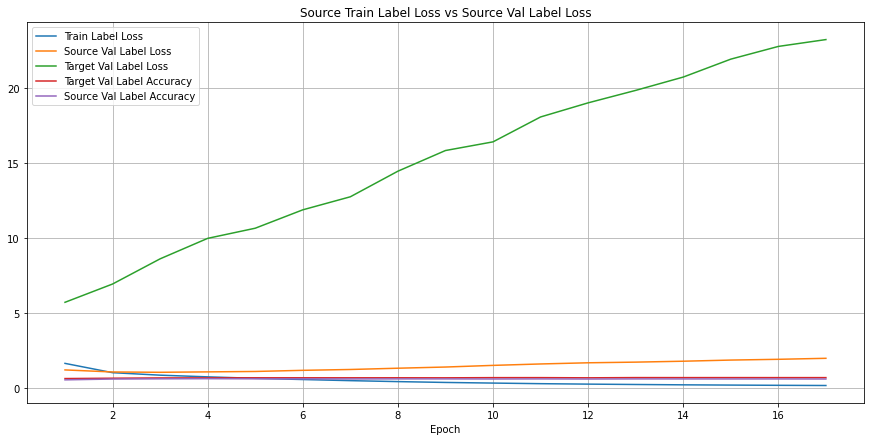

In [25]:
ax = get_loss_curve(experiment)
plt.show()

<AxesSubplot:title={'center':'Results'}>

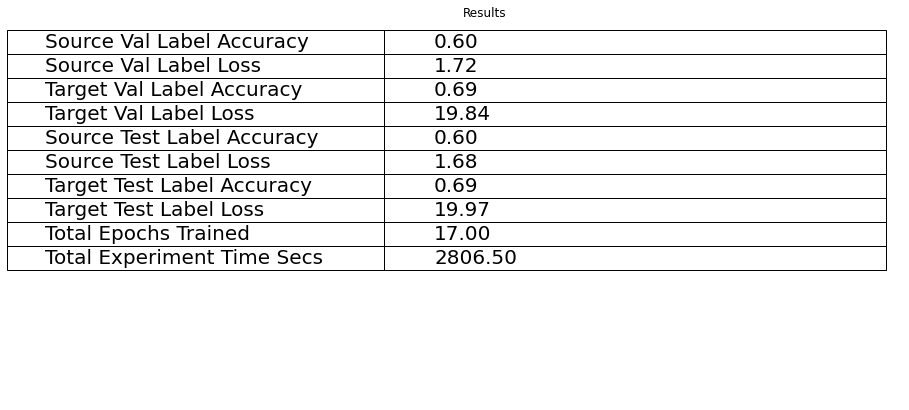

In [26]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Validation Accuracy'}, xlabel='domain'>

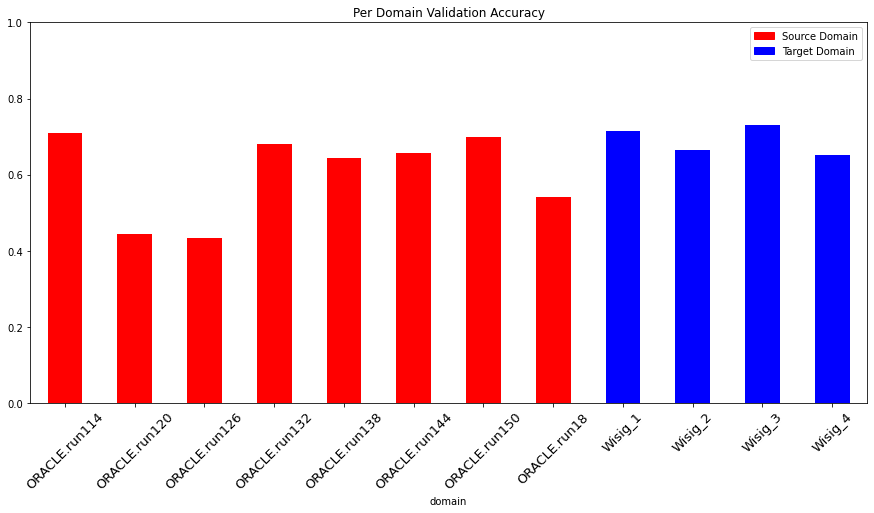

In [27]:
get_domain_accuracies(experiment)

In [28]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.6022786458333333 Target Test Label Accuracy: 0.6909505208333333
Source Val Label Accuracy: 0.6011067708333333 Target Val Label Accuracy: 0.6894551961823966


In [29]:
json.dumps(experiment)

'{"experiment_name": "tl_1v2:wisig-oracle.run1.limited", "parameters": {"experiment_name": "tl_1v2:wisig-oracle.run1.limited", "device": "cuda", "lr": 0.0001, "n_shot": 3, "n_query": 2, "train_k_factor": 3, "val_k_factor": 2, "test_k_factor": 2, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_accuracy", "x_net": [{"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}}, {"class": "Conv2d", "kargs": {"in_channels": 1, "out_channels": 256, "kernel_size": [1, 7], "bias": false, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 256}}, {"class": "Conv2d", "kargs": {"in_channels": 256, "out_channels": 80, "kernel_size": [2, 7], "bias": true, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 80}}, {"class": "Flatten", "kargs": {}}, {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}}